# Recurrent Neural Networks

---

*You can watch a [video](https://youtu.be/4wuIOcD1LLI) of this lesson if you prefer.*

---

## Table of Contents

- [Introduction](#Introduction)
- [The RNN Architecture](#The-RNN-Architecture)
	- [RNN Operations](#RNN-Operations)
	- [Forward Pass](#Forward-Pass)
		- [Nonlinearity](#Nonlinearity)
		- [Full Forward Pass](#Full-Forward-Pass)
	- [Calculating the Loss](#Calculating-the-Loss)
	- [Backward Pass](#Backward-Pass)
		- [Full Backward Pass](#Full-Backward-Pass)
- [Full Implementation](#Full-Implementation)
- [Wrap-up](#Wrap-up)

## Introduction

In the [last lesson](../4-Classification/classification.ipynb), we learned how to use a neural network to perform classification.<br>
This is one important piece of using a neural network to do NLP (natural language processing).

In this lesson, we'll learn another important piece - how to use neural networks to take in sequences of input and make predictions.<br>
A sequence of input can be a sentence made up of words, or a series of weather observations.

Each element in a sequence has a position.  We can think of those positions as being steps in time.

Here is a sequence of temperatures:

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sympy import diff, symbols, exp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Read in weather data, fill missing values
data = pd.read_csv("../data/clean_weather.csv", index_col=0)
data = data.ffill()

# First 10 data entries
print(data["tmax"].head(10), "\n")
print('Dataset Size:', len(data))

1970-01-01    60.0
1970-01-02    52.0
1970-01-03    52.0
1970-01-04    53.0
1970-01-05    52.0
1970-01-06    50.0
1970-01-07    52.0
1970-01-08    56.0
1970-01-09    54.0
1970-01-10    57.0
Name: tmax, dtype: float64 

Dataset Size: 13509


The first sequence element (at time step $0$) is $60$.<br>
The second sequence element (at time step $1$) is $52$, and so on.<br>
In total, there are $13509$ timesteps in this sequence dataset, all **sequentially related**.

Let's say we want to predict a *next element* within a sequence. Specifically, for our above sequence,<br>
we want to predict the value of time step $10$ from the preceeding steps.

With a standard dense neural network, you would have to treat each input feature *seperately*.<br>
Therefore, it becomes a question of what exactly to input into the network.<br>
One time step? Two time steps? The entire sequence?

Let's follow the path of using a dense neural network here:

In [3]:
# Turn our sequence into a single row of data
print(data["tmax"].head(10).to_numpy()[np.newaxis,:])

[[60. 52. 52. 53. 52. 50. 52. 56. 54. 57.]]


As stated prior, we could for example feed the entire sequence as a single training example into a neural network to predict the next temperature.<br>
**But what if we don't know the length of the sequence beforehand?**<br>
For example, what if we wanted the neural network to predict the next word that came after a variable-length prompt?

We could have prompts like:
- `Write me a song`
- `Tell me a story about dinosaurs`
- `Add 1 and 2`

We want our network to be able to handle these different inputs robustly.<br>
One way to do this is to add extra zeros to the end of the sequence to make all of the sequences the same, biggest, length.<br>
Then our network will handle a standard input size.

However, this introduces the problem that the neural network will have to learn parameters for each position *separately*, *independently*,<br>
without oversight of contextual development of inputs over time.

If we're passing in two weather observations of different lengths, the network will have to learn to ignore the zeros at the end of the shorter sequence, and the interplay within the sequences.

In [4]:
print(data["tmax"].head(6).to_numpy()[np.newaxis,:])
print(data["tmax"].tail(10).to_numpy()[np.newaxis,:])

[[60. 52. 52. 53. 52. 50.]]
[[64. 63. 62. 61. 60. 62. 67. 66. 70. 62.]]


The thing is, the temperatures are interrelated - the temperature today causes a rational basis for the temperature tomorrow.<br>
If we train a neural network to evaluate each position within the sequence input separately, which is what a dense neural network does,<br>
it won't be able to efficiently learn the time-directional relationship between one sequence position and the next.

Instead of the network being able to derive a rule to the extend of "all time steps are related to their previous time step",<br>
it will be architectually restrained to stating "time step $0$ is related to time step $1$, time step $1$ is related to time step $2$", and so on.<br>

> Dense Networks, applied to sequence data, lacks efficiency, as it structurally is inapt<br>
> to learn the time-directional relationship between sequence elements.

Recurrent Neural Networks (RNN) are a special kind of neural networks that solve this problem.

In this lesson, we'll learn how to build one in Python.

## The RNN Architecture

RNNs work by sharing parameters (weights and biases) across steps in a sequence.<br>
At a *very* high level, a recurrent neural network looks like this:

<div style="text-align:center;">
    <img src="../images/rnn/rnn_rolled.svg" alt="Rolled RNN">
</div>

What we see above is called a compact representation of an RNN. We pass input into an RNN, a single entry from a sequence, with the entry being of index $64$.<br>
Again, per timestep, one input is made, consisting of one sequence entry, not the entire sequence or anything like that.<br>
Each input is passed through the `Input Step (I)`, the `Hidden Step (H)` and the `Output Step (O)`,<br>
the latter of which ultimately returning a prediction for the respective next sequence entry.

The arrow connecting `H` to itself is called **Recurrence**.

> In neural networks, recurrence means that the `H` layers applied per input are connected to each other across time/sequence steps.

The effect of Recurrence unravels itself when looking at the unrolled depiction of an RNN:

<div style="text-align:center;">
    <img src="../images/rnn/rnn_unrolled.svg" alt="Unrolled RNN">
</div>

Each sequence element is labeled at the bottom with the time step of the element.<br>
The first element in the sequence is $t_0$, the second is $t_1$, and so on.<br>
You can see that each element is passed into the input step, then to the hidden step.<br>
The trick is that **the output of the hidden step is passed both to the output, and to the next hidden step**.

Therefore, at each step, an RNN is informed about inputs at previous steps.<br>
The "memory" of the network is stored in the hidden step `H`, and represented as an internal matrix of values.<br>
This matrix is updated at each time step with new information about the sequence.

Let's actually look at the exact operations that happen per each step within an RNN.

### RNN Operations

<div style="text-align:center;">
    <img src="../images/rnn/rnn_operations.svg" alt="RNN Operations">
</div>

**An RNN has $3$ steps:**
- `Input`  - Takes in a *sequence item*, multiplies it by some *input weight*,
- `Hidden` - Takes the *previous hidden state*, multiplies it by some *hidden weight*. The *input state* is added to that, then a nonlinear activation function is applied.
- `Output` - Takes the *hidden state*, multiplies it by some *output weight*.

Additionally, biases are added at the *hidden step* and *output step*, but the biases are kept out of the diagram to make it easier to read.

The trickiest architectural feat of an RNN is the hidden step.<br>
It's this step that gives an RNN its power, by enabling it to have "memory".<br>
The hidden state of the RNN stores a representation of information aggregated across previous sequence elements.<br>
The hidden weights enable the RNN to go on and selectively remember/imprint or forget/erase certain information about past sequence elements.

This way, the RNN can have trainable/focusable knowledge of past elements in the sequence without having strictly separate parameters for each sequence item.<br>
We instead reuse them, inform our current step with them, and update them with new information, as seen fit.<br>
The overall process is called **parameter sharing** - the RNN step-by-step optimizes the *same* set of input, hidden, and output weights through every sequence element.<br>
Therefore, input, hidden and output are imprints of sequence characteristics, not of individual sequence elements. This is efficient, compared to dense neural networks.

In addition to the sequence-focus, *parameter sharing* enables the RNN to be used for sequences of variable length - **we don't require a fixed size input sequence length**.

### Forward Pass

Let's go through an example to see how RNNs are implemented.<br>
We'll initialize each weight matrix, and then do a sample forward pass with a sequence of length $3$.

In [5]:
np.random.seed(0) # Seed for reproducibility

i_weight = np.random.rand(1,2) # Input weight,  (1,2) matrix
h_weight = np.random.rand(2,2) # Hidden weight, (2,2) matrix
o_weight = np.random.rand(2,1) # Output weight, (2,1) matrix

# Assemble a sequence of 3 temperature values from dataset
temps = data["tmax"].tail(3).to_numpy()
print(temps)

[66. 70. 62.]


The network will take in a single input feature, turn it into $2$ representing hidden features, and then turn that into a single output feature.<br>
We can now format our input for the forward pass.<br>
Specifically, we will reshape each input scalar into a $1\times 1$ matrix to make multiplication more straightforward:

In [6]:
# Reshape each scalar to a (1,1) matrix, 
# Assign reshaped sequence input at each time step to respective variable.
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)

We can go on and feed the element at time step $0$ into our network:

In [7]:
# Multiply input by input weight to get input result for time step 0
xi_0 = x0 @ i_weight

# There is no previous time step, so there is no hidden state
# Apply ReLU to input result, makes for initial hidden state
xh_0 = np.maximum(0, xi_0)

# Get output result at time step 0
xo_0 = xh_0 @ o_weight

print(f'Input result at t=0:\t{xi_0}')
print(f'Hidden state at t=0:\t{xh_0}', "\n")
print(f'RNN Output - Step 0:\t{xo_0}')
print(f'Actual next temperature:\t{x1}')

Input result at t=0:	[[36.22169126 47.20249818]]
Hidden state at t=0:	[[36.22169126 47.20249818]] 

RNN Output - Step 0:	[[57.94406231]]
Actual next temperature:	[[70.]]


`xo_0` is the RNN's prediction for the next step in the sequence.<br>
With `xo_0` derived, we can move the network forward to time step $1$.<br>
Notice how we didn't yet do anything to optimize the weights. This will happen later.

In [8]:
# We feed the input in the same way as the previous time step
xi_1 = x1 @ i_weight

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_0 by the hidden weights
xh = xh_0 @ h_weight

# We add the previous hidden state (times h_weight) to the input at time step 1
xh_1 = np.maximum(0, xh + xi_1)

# We again find the output by multiplying xh_1 by the output weight
xo_1 = xh_1 @ o_weight

print('RNN Output - Step 1:', xo_1)

RNN Output - Step 1: [[124.54916092]]


`xo_1` is our prediction for the next sequence element.<br>
Now we can do the same for our final time step $2$.<br>
Notice how we use `i_weight`, `h_weight`, and `o_weight` again for this time step:

In [9]:
# We feed the input in the same way as the previous time step
xi_2 = x2 @ i_weight

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_1 by the hidden weights
xh = xh_1 @ h_weight

# We add the previous hidden state (times h_weight) to the input at time step 2
xh_2 = np.maximum(0, xh + xi_2)

# We again find the output by multiplying xh_1 by the output weight
xo_2 = xh_2 @ o_weight

print('RNN Output - Step 2:', xo_2)

RNN Output - Step 2: [[190.94853131]]


We've now passed through $3$ forward steps of our RNN!<br>
The output `x0` at each time step $i$ is the prediction for the respective next element $i+1$ in the sequence.<br>
The hidden state of the RNN allows the network to utilize information from all prior sequence elements.<br>
Therefore, when we're processing the sequence item at time step $2$, the hidden state of the RNN aggregates information about the sequence elements at time steps $0$ and $1$.

#### Nonlinearity

You may have noticed that the output values increased in each time step of our RNN.<br>
That happened because the hidden state kept increasing in size.<br>
Unlike the *Sigmoid* or *Softmax* activation functions, *ReLU* doesn't change the scale of the positive inputs at all.<br>
This means that some positive values get repeatedly multiplied and therefore grow larger and larger.

We can see this below:

In [10]:
print(f'Hidden State - Step 0: {xh_0}\tOutput: {xo_0}\t\tActual: {x0}')
print(f'Hidden State - Step 1: {xh_1}\tOutput: {xo_1}\tActual: {x1}')
print(f'Hidden State - Step 2: {xh_2}\tOutput: {xo_2}\tActual: {x2}')

Hidden State - Step 0: [[36.22169126 47.20249818]]	Output: [[57.94406231]]		Actual: [[66.]]
Hidden State - Step 1: [[ 80.24761908 100.28766177]]	Output: [[124.54916092]]	Actual: [[70.]]
Hidden State - Step 2: [[124.88411227 152.84252918]]	Output: [[190.94853131]]	Actual: [[62.]]


Our hidden state at time step $2$ is much larger than our initial hidden state.<br>
To fix this, we usually replace our ReLU with the $\tanh$ activation function for RNNs.

The equation for $\tanh$ is this:
$$\tanh = \dfrac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

As $x$ gets large, $e^{x}$ gets very large, and $e^{-x}$ gets very small. This pushes the output of $\tanh$ towards $1$.<br>
Then in turn, when $x$ gets very small (negative), $e^{-x}$ gets very large, and $e^{x}$ gets very small. This results in trending towards $-1$.

Let's graph the $\tanh$ function to see how this works:

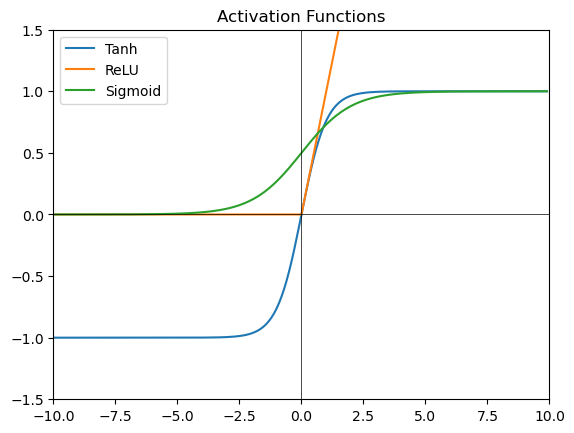

In [11]:
# Define some temperature values
temps = np.arange(-10, 10, .1)

plt.title('Activation Functions')
plt.plot(temps, np.tanh(temps), label='Tanh')
plt.plot(temps, np.maximum(0, temps), label='ReLU')
plt.plot(temps, 1/(1+np.exp(-temps)), label='Sigmoid')
plt.ylim(-1.5, 1.5)
plt.xlim(-10, 10)
plt.axhline(0, color='black', lw=.5)
plt.axvline(0, color='black', lw=.5)
plt.legend()
plt.show();

$\tanh$ outputs values between $-1$ and $1$. Additionally, it has a very steep slope around $0$ on the x-axis.<br>
The $\tanh$ activation function is better for our purposes compared to Sigmoid, because it enables us to have *negative values*.<br>
This enables the gradient to be steeper, which aids in gradient descent.<br>
You can also view this from a totally different perspective: In enabling negative values,<br>
$\tanh$ allows for the hidden state to learn to forget certain information through scaling down the values, too.

Let's take a look at the derivative of $\tanh$ using sympy:

In [12]:
x = symbols("x")

# tanh
sympy_tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))

# Derivative of tanh
diff(sympy_tanh, x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

While the result is technically correct, Sympy doesn't quite simplify the derivative all the way.<br>
Like the derivatives of sigmoid and softmax, we can express the derivative of $\tanh{x}$ in terms of the output: $1 - \tanh^2{x}$.

We can then graph this derivative:

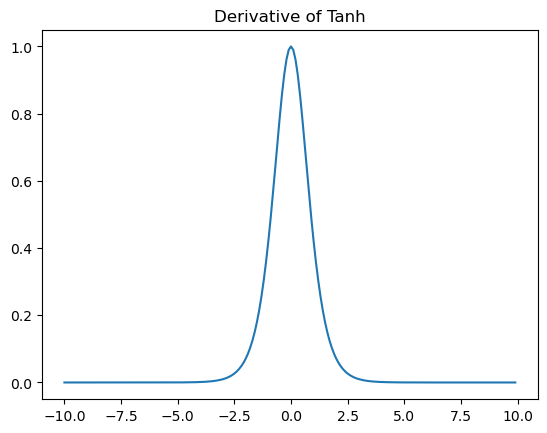

In [13]:
plt.title('Derivative of Tanh')
plt.plot(temps, 1 - np.tanh(temps) ** 2);

As you can see, the derivative has a steep slope, making $\tanh$ an ideal activation function.<br>
We can say that because this slope will enable gradient descent to descend effectively and quickly.<br>
We can now go on with our own implementation and use $\tanh$ instead of ReLU.

#### Full Forward Pass

We now know enough to put together a *complete* RNN forward pass.<br>
We'll first initialize our weights and biases. We'll add in bias terms in the hidden and output steps.

We'll also scale the weights and biases to work properly with the $\tanh$ nonlinearity.<br>
We'll make our input and hidden weights small, so that $\tanh$ doesn't squash all the values to its extremes $1$ or $-1$.<br>
We'll make the output weight large, since the output of the hidden step will be small (between $1$ and $-1$), yet we actually want to cover some output value range.

Of course, in a comprehensive RNN implementation, the network would eventually learn the correct parameters.<br>
But initializing weights and biases to the correct ranges helps *a lot* with gradient descent.

In [14]:
np.random.seed(0) # Reproducibility

# Define weights and biases
# Scale w and b so tanh activations don't radicalize too much
i_weight = np.random.rand(1,5) / 5 - .1 # we sample values [-0.1;0.1]
h_weight = np.random.rand(5,5) / 5 - .1
h_bias   = np.random.rand(1,5) / 5 - .1

# Tanh pushes values to between -1 and 1, so scale up the output weights
# We sample large output values, allowing for displaying larger ranges despite tanh input
o_weight = np.random.rand(5,1) * 50
o_bias   = np.random.rand(1,1)

Now we can write the forward pass as a for loop.<br>
The loop will process sequence elements one after another.

We'll store the output prediction and the hidden state, respectively:

In [15]:
# RNN Forward Pass for sequences of 3 time steps
seq_length = 3

outputs = np.zeros(seq_length)   # Array to store the output predictions
hiddens = np.zeros((seq_length, 5)) # Array to store hidden states for use in backprop

# This will store the previous hidden state, 
# We'll need prev_hidden to calculate the current hidden step
prev_hidden = None

# Our temperature sequence to train on
sequence = data["tmax"].tail(seq_length).to_numpy()

for i in range(len(sequence)):
    # Get scalar input from sequence at current position
    x = sequence[i].reshape(1,1)

    # Multiply input by input weight
    xi = x @ i_weight

    if prev_hidden is None:
        # Init hidden as input
        xh = xi
    else:
        # Add prev hidden to input + bias
        xh = xi + (prev_hidden @ h_weight) + h_bias

    # Apply tanh to hidden state
    xh = np.tanh(xh)
    # Store hidden state for next iteration
    prev_hidden = xh
    # Store hidden state for backprop
    hiddens[i,] = xh

    # Multiply hidden state by output weight, add bias
    xo = xh @ o_weight + o_bias
    # Store output
    outputs[i] = xo[0,0]

Afterwards, we can take a look at our outputs and hidden states.<br>
As we can see, the hidden states don't increase constantly anymore:

In [16]:
print(outputs, "\n")
print(hiddens)

[74.31470595 80.66149404 77.67852446] 

[[ 0.56784618  0.99320288  0.87557333  0.53166114 -0.76483255]
 [ 0.58366756  0.99568651  0.90034879  0.69338529 -0.84149203]
 [ 0.5383306   0.99164251  0.86287584  0.66091071 -0.80543591]]


### Calculating the Loss

After we progressed through our forward pass, we can head on to calculating the gradient with respect to the network outputs.<br>
We will be determining the mean squared error `mse`. From there, we'll also calculate `mse_grad`:

In [17]:
def mse(actual, predicted):
    return np.mean((actual-predicted)**2)

def mse_grad(actual, predicted):
    return (predicted - actual)

In [18]:
# Actual next day temperatures
actuals = data["tmax_tomorrow"].tail(seq_length).to_numpy()

loss_grad = mse_grad(actuals, outputs)
print(loss_grad)

[ 4.31470595 18.66149404 13.67852446]


### Backward Pass

Now that we've written a forward pass, let's think about the backward pass to update our model parameters.<br>
The main complexity in the backward pass is that parameters impact both the current and future outputs.

Let's visualize this, starting with the last sequence item:

<div style="text-align:center;">
    <img src="../images/rnn/gradient_last.svg" alt="Gradient Last">
</div>

As you can see above, the last hidden step is only used by the output of the last time step.<br>
But this is different for other hidden steps:

<div style="text-align:center;">
    <img src="../images/rnn/gradient_inside.svg" alt="Gradient Inside">
</div>

The hidden step at time step $2$ is connected to both the output and the next hidden state.<br>
So it affects not just the current output, but all subsequent outputs, too.

We have to consider this fact when we do backpropagation: **Some parameters will impact multiple outputs**.<br>
These parameters need to get gradients assembled from multiple outputs in order to be correctly adjusted.

> We'll have to send the gradient with respect to each hidden step backwards to the previous sequence position.<br>
> This is called backpropagation through time, and it's how we train the parameters of an RNN.

Here are the operations we will follow to do a backward pass:

<div style="text-align:center;">
    <img src="../images/rnn/rnn_operations_bw.svg" alt="RNN Operations">
</div>

Let's implement the backward pass one by one for each sequence element.

We start out by creating variables to store the gradients with respect to each parameter.<br>
We do this because we want to sum the gradients across time positions before making updates with gradient descent:

In [19]:
# Aggregators, keeping running total of gradients
o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5

Then, we can run backpropagation for the last sequence element.<br>
In this case, there is no next hidden state, so we only need to worry about the gradient wrt the output at this position:

In [20]:
# Get the loss wrt the output at the current time step
l2_grad = loss_grad[2].reshape(1,1)

# Add to the output weight gradient
# Multiply the output of the hidden step (hiddens[2]) transposed by the l2 grad
# np.newaxis creates a new size 1 axis, effectively transposing the hiddens
o_weight_grad += hiddens[2][:,np.newaxis] @ l2_grad
# Add to the bias gradient.  Similar to a dense neural network, this is just the mean of the l2_grad.
o_bias_grad += np.mean(l2_grad)

# Find the gradient wrt the hidden step output
h2_grad = l2_grad @ o_weight.T

# Derivative of the tanh function
tanh_deriv = 1 - hiddens[2,:][np.newaxis,:] ** 2
# Multiply each position in the h_grad by the tanh derivative - this "undoes" the tanh in the forward pass
h2_grad = np.multiply(h2_grad, tanh_deriv)

# Now, find how much we need to update the hidden weights.
# We take the input to the hidden step (the output of the previous hidden step in the forward pass) @ h2_grad
h_weight_grad += hiddens[1,:][:,np.newaxis] @ h2_grad
h_bias_grad += np.mean(h2_grad)

# This multiples the sequence value at time step 2 by the gradient
# We don't need the .T here, but I left it here in case you have a larger input size
i_weight_grad += sequence[2].reshape(1,1).T @ h2_grad

A lot of the above step is very similar to backpropagation in a [dense neural network](../3-Dense_Networks/dense.ipynb).<br>
The main difference comes in the next sequence position, where we need to consider multiple gradients at the hidden step:

In [21]:
l1_grad = loss_grad[1].reshape(1,1)

o_weight_grad += hiddens[1][:,np.newaxis] @ l1_grad
o_bias_grad += np.mean(l1_grad)

h1_grad = l1_grad @ o_weight.T

# We do have a next sequence position (2), so we need to include that gradient
# We multiply the h2 gradient by the weight to pull it back to the current sequence position
h1_grad += h2_grad @ h_weight.T

# The rest of the operation is the same
tanh_deriv = 1 - hiddens[1,:][np.newaxis,:] ** 2
h1_grad = np.multiply(h1_grad, tanh_deriv)

h_weight_grad += hiddens[1,:][:,np.newaxis] @ h1_grad
h_bias_grad += np.mean(h1_grad)

i_weight_grad += sequence[1].reshape(1,1).T @ h1_grad

Now, we can do the final sequence position, $0$.<br>
The main difference here is that we don't update the hidden gradient, since<br>
there is no previous sequence position that gave us hidden state input in the forward pass:

In [22]:
l0_grad = loss_grad[0].reshape(1,1)

o_weight_grad += hiddens[0][:,np.newaxis] @ l0_grad
o_bias_grad += np.mean(l0_grad)

h0_grad = l0_grad @ o_weight.T
h0_grad += h1_grad @ h_weight.T

tanh_deriv = 1 - hiddens[0,:][np.newaxis,:] ** 2
h0_grad = np.multiply(h0_grad, tanh_deriv)

# We don't update the hidden weight, since there was no previous hidden state
# We can update the hidden bias if you want

i_weight_grad += sequence[0].reshape(1,1).T @ h0_grad

We can now look at our gradient updates:

In [23]:
print('Output Weight Gradient:', o_weight_grad, "\n")
print('Output Bias Gradient:', o_bias_grad, "\n")
print('Hidden Weight Gradient:', h_weight_grad, "\n")
print('Hidden Bias Gradient:', h_bias_grad, "\n")
print('Input Weight Gradient:', i_weight_grad)

Output Weight Gradient: [[ 20.7057662 ]
 [ 36.43058259]
 [ 32.38256333]
 [ 24.27385028]
 [-30.02070081]] 

Output Bias Gradient: 36.65472444998886 

Hidden Weight Gradient: [[ 414.96700557    7.11705057  128.09069049  490.00406461  206.76584453]
 [ 707.89791607   12.14107435  218.51166876  835.90466603  352.72469496]
 [ 640.11616967   10.97855755  197.58901567  755.86617912  318.95104586]
 [ 492.97243446    8.45491256  152.16915725  582.11494741  245.6336537 ]
 [-598.27109131  -10.2608775  -184.67241047 -706.45439889 -298.10087499]] 

Hidden Bias Gradient: 427.27906887063534 

Input Weight Gradient: [[56026.07073088   960.33350651 16758.78602233 67910.52141452
  28061.23683219]]


We've now completed backpropagation across $3$ time steps!<br>
We'll see how to make the gradient updates in the next section.

#### Full Backward Pass

Similar to a forward pass, we can implement the full backward pass as a loop.<br>Here we go:

In [24]:
next_hidden = None
o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5
loss_grad = mse_grad(actuals, outputs) # Gradient of mse across all sequence steps, yields (seq_length,1) matrix

# Iterating from 2 to 0 (inclusive of 0)
for i in range(2, -1, -1):
    # Plug out current loss gradient scalar into (1,1) matrix
    l_grad = loss_grad[i].reshape(1,1)
    # Add to the output weight gradient
    # Multiply the output of the hidden step transposed by the l_grad
    # np.newaxis creates new size 1 axis, effectively transposing the hiddens
    o_weight_grad += hiddens[i][:,np.newaxis] @ l_grad
    # The bias grad is just the mean of the l_grad, like in DNNs.
    o_bias_grad += np.mean(l_grad)
    # Gradient of output layer w.r.t the loss
    o_grad = l_grad @ o_weight.T

    # Gradient calculation is different, given a next hidden state
    if next_hidden is None:
        # We're at the end of a sequence
        h_grad = o_grad
    else:
        # We're at the start or within a sequence
        h_grad = o_grad + next_hidden @ h_weight.T

    # Derivative of tanh being applied to hidden state
    tanh_deriv = 1 - hiddens[i,:][np.newaxis,:] ** 2
    # The actual h_grad is bare gradient affected/multiplied by activation function derivative
    h_grad = np.multiply(h_grad, tanh_deriv)

    # Store current hidden state for next/earlier cell gradient calculation
    next_hidden = h_grad

    # Don't update hidden weights for initial (chronologically first) sequence position
    if i > 0:
        h_weight_grad += hiddens[i-1,:][:,np.newaxis] @ h_grad
        h_bias_grad += np.mean(h_grad)

    # Ultimately, update input weight gradient
    i_weight_grad += sequence[i].reshape(1,1).T @ h_grad

We can then use gradient descent to make parameter updates:

In [26]:
lr = 1e-6 # We'll just use this fixed learning rate for now

# Dividing the learning rate by the sequence length applies the learning rate across the update,
# not per time step. While this may seem counterintuitive, this helps stabilize training.
lr = lr / seq_length

# Gradient Descent Update
i_weight -= i_weight_grad * lr
h_weight -= h_weight_grad * lr
h_bias -= h_bias_grad * lr
o_weight -= o_weight_grad * lr
o_bias -= o_bias_grad * lr

## Full Implementation

We can now go on to do a full implementation of a complete network for a sequence length of $3$ and a time step input's dimensionality of $1$.<br>
For the full implementation, we'll use $3$-dimensional inputs and a sequence length of $7$.<br>
This code will mostly be the same as the forward and backward passes we already implemented, just a bit more condensed.

First, we'll load in and scale our data:

In [29]:
# Define predictor fields to consider, target to predict for
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Reproducibly split into train, valid, test set
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

# Standardize each dataset individually to avoid data leakage
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
valid_x = scaler.fit_transform(valid_x)
test_x = scaler.fit_transform(test_x)

We can now initialize our weights and biases.<br>
We'll scale our parameters so they start out relatively small.<br>

This helps the network converge meaningfully, because $\tanh$ will meaningfully scale the values not just to extremes.

In [30]:
def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        
        # Weights for input layer
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k
        
        # Weights + Bias for hidden layer
        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k
        
        # Weights + Bias for output layer
        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k
        
        # Append the weights and biases to the layers list
        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

The forward pass now looks something like this:

In [31]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        # Unpack weights and biases
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        
        # Shaping Hidden state (seq_len, hidden_units) and Output (seq_len, output_units)
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        
        # Iterate over each time step
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            
            # Activation. tanh squashes values between -1 and 1; 
            # Allows for incrementing/decrementing scales to retain/forget
            hidden_x = np.tanh(hidden_x)
            
            # Store hidden for use in backprop
            hidden[j,:] = hidden_x
            
            # Output layer
            output_x = hidden_x @ o_weight + o_bias
            
            # Store output for use in backprop
            output[j,:] = output_x
       
        # Store hidden state and output for use in backprop
        hiddens.append(hidden)
        outputs.append(output)
   
    # We want all hidden states and only the 'next in line' prediction
    return hiddens, outputs[-1]

And the backward pass:

In [32]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            # Add newaxis in the first dimension
            out_grad = grad[j,:][np.newaxis, :]

            # Output updates
            # np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad

            # Propagate gradient to hidden unit
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad

            # Pull the gradient across the current hidden nonlinearity
            # derivative of tanh is 1 - tanh(x) ** 2
            # So we take the output of tanh (next hidden state), and plug in
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

            # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
            # Effect is to pull value across nonlinearity
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute h grad for previous sequence position
            next_h_grad = h_grad.copy()

            # If we're not at the very beginning
            if j > 0:
                # Multiply input from previous layer by post-nonlinearity grad at current layer
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        # Normalize lr by number of sequence elements
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

We can conclude by setting up a training loop and measuring error:

In [34]:
epochs = 250
lr = 1e-5
sequence_len = 7

# Per time step: Three inputs, Four hidden units, One output
layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1}
]

# Initialize weights and biases
layers = init_params(layer_conf)

# Training Loop
for epoch in range(epochs):
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0 or epoch == epochs - 1:
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch+1}\t Train Loss: {epoch_loss / len(train_x)}\t Val Loss: {valid_loss / len(valid_x)}")

Epoch: 0	 Train Loss: 3127.0305785639307	 Val Loss: 2173.940590560558
Epoch: 50	 Train Loss: 29.69054028769555	 Val Loss: 34.48611521186155
Epoch: 100	 Train Loss: 25.06454162741681	 Val Loss: 27.155395197347143
Epoch: 150	 Train Loss: 22.889655164162015	 Val Loss: 23.846369196866874
Epoch: 200	 Train Loss: 22.235640463748837	 Val Loss: 22.853770518905
Epoch: 249	 Train Loss: 22.08072534106742	 Val Loss: 22.54001365658709


The network reduces training *and* validation loss over successive epochs.<br>
Our literal implementation will perform similarly to the RNN implementation in Pytorch, but it will descend *way* more slowly.

Anyway, let's see how our own, trained RNN performs on a test sequence:

In [53]:
# Test the model on test_x, test_y
test_loss = 0
for j in range(test_x.shape[0] - sequence_len):
    seq_x = test_x[j:(j+sequence_len),]
    seq_y = test_y[j:(j+sequence_len),]
    _, outputs = forward(seq_x, layers)
    test_loss += mse(seq_y, outputs)
    if j % int(test_x.shape[0] / 10) == 0:
        print(f"Predicted: {outputs[-1][0]:.2f}\tActual: {seq_y[-1,0]}")

print(f"Test loss: {test_loss / len(test_x):.4f}")

Predicted: 64.20	Actual: 69.0
Predicted: 59.75	Actual: 67.0
Predicted: 70.65	Actual: 70.0
Predicted: 61.25	Actual: 61.0
Predicted: 69.33	Actual: 75.0
Predicted: 63.64	Actual: 71.0
Predicted: 81.96	Actual: 68.0
Predicted: 66.84	Actual: 82.0
Predicted: 62.35	Actual: 68.0
Predicted: 62.57	Actual: 60.0
Test loss: 38.4535


## Wrap-up

We learned a lot in this lesson! You should now have a good idea of how to train a recurrent neural network.<br>
If some of the concepts immediately, don't worry about it.<br>
RNNs are *tricky*, and take multiple readings and hands-on trials to really understand.

In the next lesson, we'll learn about how we can reduce test and validation error with regularization.